In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
train_df = pd.read_csv("titanic/train.csv")
#serving_df = pd.read_csv("titanic/test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
def preprocess(df):
    df = df.copy()

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        return x.split(" ")[-1]

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train_df = preprocess(train_df)
#preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [5]:
# Display basic info
print("--- Initial Data Info ---")
preprocessed_train_df.info()
print("\n--- First 5 Rows ---")
print(preprocessed_train_df.head())
print("\n--- Missing Values Before Preprocessing ---")
print(preprocessed_train_df.isnull().sum())

(891, 14)


# Plot the relationship between age and survival

/var/folders/4j/39rtwmqd5tg4g8dn1t6m037h0000gn/T/ipykernel_33987/2526280251.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[age_group_col] = pd.cut(df_cleaned[age_col],


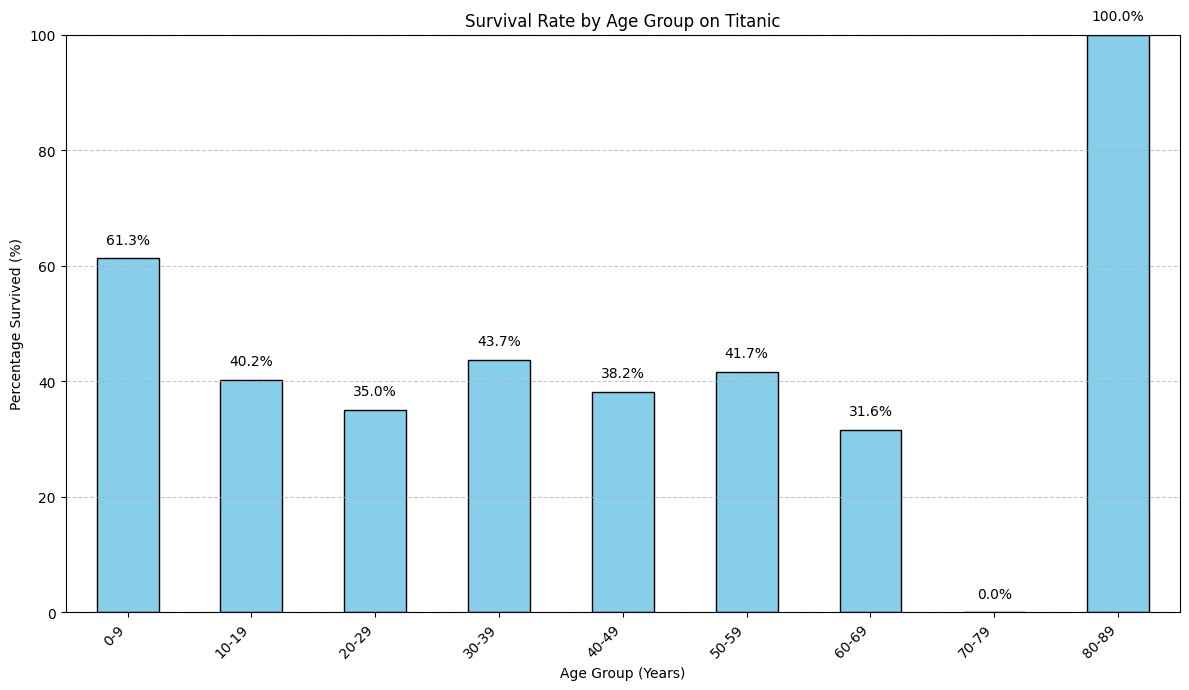


Survival Rate by Age Group (%):
Age_Group
0-9       61.290323
10-19     40.196078
20-29     35.000000
30-39     43.712575
40-49     38.202247
50-59     41.666667
60-69     31.578947
70-79      0.000000
80-89    100.000000
Name: Survived, dtype: float64


In [13]:
age_col = "Age"
survive_col = "Survived"
age_group_col = "Age_Group"

# Remove rows where age is missing, as it can't be plotted
df_cleaned = preprocessed_train_df.dropna(subset=[age_col])

# 2. Define Age Bins
# You can customize these bins based on your data's range and desired granularity
min_age = int(df_cleaned[age_col].min())
max_age = int(df_cleaned[age_col].max())

# Let's create bins of 10 years, for example
age_bins = list(range(0, max_age + 15, 10)) # e.g., [0, 10, 20, ..., max_age rounded up to nearest 10]
age_labels = [f'{i}-{i+9}' for i in age_bins[:-1]]
# Ensure the last bin captures up to max_age correctly.
# If max_age is 66, age_bins might be [0, 10, 20, 30, 40, 50, 60, 70].
# Labels: 0-9, 10-19, ..., 60-69.

# Create a new column for age groups
# `right=False` means bins are [0,10), [10,20), etc.
# `include_lowest=True` ensures the lowest age is included if it falls on a bin edge.
df_cleaned[age_group_col] = pd.cut(df_cleaned[age_col],
                                 bins=age_bins,
                                 labels=age_labels,
                                 right=False,
                                 include_lowest=True)

# Handle cases where age_group might be NaN if pd.cut didn't assign a label (e.g., max_age exactly on last bin edge with right=False)
df_cleaned = df_cleaned.dropna(subset=[age_group_col])


# 3. Calculate Survival Rate per Age Group
# Group by the new 'age_group' and calculate the mean of 'survived'
# .mean() on a 0/1 column gives the proportion of 1s (survivors)
survival_rate_by_age_group = df_cleaned.groupby(age_group_col, observed=False)[survive_col].mean() * 100

# If there are age groups with no people after filtering, they might not appear or result in NaN.
# Let's ensure we handle that for plotting if necessary, though groupby().mean() should handle empty groups correctly (results in NaN).
survival_rate_by_age_group = survival_rate_by_age_group.fillna(0) # Fill NaN with 0% survival if an age group had no one or no survivors

# 4. Plot the Bar Chart
plt.figure(figsize=(12, 7))
bars = survival_rate_by_age_group.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Survival Rate by Age Group on Titanic')
plt.xlabel('Age Group (Years)')
plt.ylabel('Percentage Survived (%)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100) # Survival rate is between 0 and 100%

# Add percentage labels on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.1f}%', ha='center', va='bottom')


plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# You can also save the plot:
# plt.savefig('survival_rate_by_age_group.png')

# To see the data behind the plot:
print("\nSurvival Rate by Age Group (%):")
print(survival_rate_by_age_group)

In [18]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924
